# Backend (Demo)

In [1]:
import re
import string
import math
from math import log
from dateutil import parser
from threading import Thread
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from time import time
from timeit import timeit
import pandas as pd
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Text Preprocess

In [84]:
english_stopwords = frozenset(stopwords.words('english'))
corpus_stopwords = [
    'category', 'references', 'also', 'links', 'extenal', 'see',"links",
                    "may", "first","history", "people", "one", "two",
                    "part", "thumb", "including", "second", "following",
                    "many", "however", "would", "became", '.', ',', '?', '!', ':', ';', '/', '\\', '-', '"', "'", "(", ")",
    "[", "]", "{", "}", "|", "*", "+", "@", "^", "&", "%", "#", "''",'``','...', '',' ', None
]
corpus_stopwords = set(corpus_stopwords + list(string.punctuation))

ALL_STOPWORDS = english_stopwords.union(corpus_stopwords)
lemmatizer = WordNetLemmatizer()

def replace_contractions(token):
    """
    Replace common contractions like "n't" with their full words.

    Parameters:
        tokens (list of str): List of tokens.

    Returns:
        list of str: List of tokens with contractions replaced.
    """
    contractions_mapping = {
        "n't": "not",
        "'nt": "not",
        "'ll": "will",
        "'ve": "have",
        "'re": "are",
        "'d": "would",
        "'m": "am",
        ".": "",
        "'s": "is"
    }

    for key in contractions_mapping.keys():
        if key in token:
            i = token.index(key)
            if key == ".":
                return [token[:i], token[i+1:]]
            return [token[:i], contractions_mapping[key]]
    return [token]

def ParseDateFromToken(token):
    def is_likely_date(token):
        # Check for delimiters typically found in numeric shaped dates
        if re.search(r'(\d{1,4}[- /.]\d{1,2}[- /.]\d{1,4})', token):
            return True
        return False

    if not is_likely_date(token):
        return None

    try:
        parsed_date = parser.parse(token, ignoretz=True)

        # Validate year range to prevent OverflowError
        if parsed_date.year < 1 or parsed_date.year > 9999:
            return None

        # Further validation to ignore times without explicit dates
        if parsed_date.hour != 0 or parsed_date.minute != 0 or parsed_date.second != 0:
            # This means the token was more like a time than a date
            return None

        year = parsed_date.year
        full_month_name = parsed_date.strftime("%B")
        return str(year), full_month_name
    except (ValueError, OverflowError, TypeError):
        return None

def PreProcessText(text):
    '''
    Parse input text. Titles - all lowered, body - keeps capitalization under conditions.
    Out is a final list of lemmatized tokens.
    '''
    in_tokens = word_tokenize(text)

    tok_tmp = []
    for token in in_tokens:
      tmp = replace_contractions(token)
      tok_tmp.extend(tmp)

    tokens = [token.lower().strip(string.punctuation) for token in tok_tmp if token not in ALL_STOPWORDS]
    tok_tmp = []
    for token in tokens:
        date_data = ParseDateFromToken(token)  # list of 2 or None
        if date_data is not None:
            tok_tmp.extend(date_data)

    tokens.extend(tok_tmp)
    return tokens

def Extend_Query(tokens):
  '''
  Function extends query (specifically entity words) with synonims.
  Input are the initial tokens from the split action.
  '''
  def get_primary_synonyms(word):
    synonyms = set()
    synsets = wn.synsets(word)
    if synsets:
        primary_synset = synsets[0]
        synonyms.update(lemma.name() for lemma in primary_synset.lemmas())
    synonyms = list(synonyms)

    # Split to singular words:
    final_synonyms = []
    for term in synonyms:
      tmp = term.split('_')
      final_synonyms.extend(tmp)
    return final_synonyms

  tokens_final = []
  for token in tokens:
    ex = get_primary_synonyms(token)
    if len(ex) > 0:
      tokens_final.extend(ex)
  return set([token.lower() for token in tokens_final if token not in ALL_STOPWORDS])

def possible_containing_entity(query):
    '''
    Based on the existence of mid-sentence capitalization or number
    '''
    query = query[1:]
    # Regular expression pattern to match capitalized words or words containing numbers not at the beginning of the query
    entity_pattern = r'\b[A-Z0-9][a-z0-9]*\b'
    # Find all matches of the pattern in the query
    matches = re.findall(entity_pattern, query)
    # Return True if there are any matches, False otherwise
    return bool(matches)

def EntitiesKeywords(query):
    """
    Assuming there might be an entity in this query, try to get it.
    Will be used to calculate similarity score only for tokens with capital letters or numbers (additional similarity score)
    and to expand the query with important terms.
    """
    # Split the query into tokens
    tokens = word_tokenize(query)
    # lower first char and determine if first word needs to be included
    first = tokens[0][0].lower()
    # Extract tokens with capital letters or numbers
    entity_tokens = [token for token in tokens[1:] if any(char.isupper() or char.isdigit() for char in token)]
    if any(char.isupper() or char.isdigit() for char in first):
      entity_tokens.append(tokens[0])
    return ' '.join(entity_tokens)


In [3]:
def PreprocessQuery(query, expand = True, synonims = True, expansion_param = 2):
  '''
  Query preprocess is similar to body's - keeps mid query capitalization in an attempt to catch entities.
  In addition, adds lowered version of the capitalized word so that will be looked for too
  (in the title, which cannot keep the capitalization).
  Synonims are looked for only for entities
  '''
  extension = []
  # Tokenize the text
  if expand:
    original_tok = PreProcessText(query)
    if possible_containing_entity(query) or len(original_tok) == 1:
      entities = EntitiesKeywords(query)
      query = query + ' ' + (entities+' ') * (expansion_param - 1)
      if synonims:
        # If query has 1 word, treat as entity
        if len(original_tok) == 1:
          extension = Extend_Query(original_tok)
        else:
          # Expand only entities
          extension = Extend_Query(entities.split())
  tokens = PreProcessText(query)
  tokens.extend(extension)
  # For query, lemmatization only happens after expantion
  tokens = [lemmatizer.lemmatize(token) for token in tokens]
  return tokens

### Retrieval Functions

In [4]:
'''
================================================================================
For Space and calculation efficiency, pass retrieval methods only necessary data
================================================================================
'''

def _get_postings(term, method, inverted, BUCKET_NAME, PageRank, PageViews):
    '''
    This function is a worker function desined to retrive and design a data structure from posting for 1 term.
    Will be activated through ThreadPool in order to minimize IO time.
    '''
    docs = inverted.read_a_posting_list('', term, BUCKET_NAME)
    index, idf = inverted.term_data[term]
    d = []

    for doc in docs:
        if doc[0] not in inverted.additional_info:
            continue
        pageviews = log(PageViews.get(doc[0], 0) +1 )  # limit values growth
        pagerank = log(PageRank.get(doc[0], 0) + 1)  # limit values growth
        info = inverted.additional_info[doc[0]]

        if method == 'Cosine':
            title = info[0]
            data = (doc[0], title, pagerank, pageviews)
        elif method == 'BM25':
            title, doc_size = info[0], info[1]
            data = (doc[0], title, doc[1], doc_size, pagerank, pageviews)

        d.append(data)

    if method == 'Cosine':
        return (term, index, idf), d
    elif method == 'BM25':
        return (term, idf), d

def RetrieveFromPosting(query_tokens, inverted, BASE_DIR, BUCKET_NAME, PageRank, PageViews, method='BM25'):
    '''
    ThreadPool wrapper designed to get the postings for the entire query (query_tokens).
    method parameter exists because for memory efficiency, different methods require different structure.
    '''
    fetched_docs = {}
    query_tokens = list(set([token for token in query_tokens if token in inverted.df]))  # Ensure uniqueness and filter irrelevant tokens

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(_get_postings, term, method, inverted, BUCKET_NAME, PageRank, PageViews) for term in query_tokens]
        for future in futures:
            key, value = future.result()
            fetched_docs[key] = value

    return fetched_docs

### Similarity Functions

In [5]:
def CosineSimilarity(fetched_docs, doc_vectors, query_tokens ,threshold=0.1):
  '''
  In classic CosineSimilarity we'll take a corpus size vector with entries for term in query and DOT PRODUCT it with corpus size vector for document
  with entries for terms and appearences in the doc. In order to be computationally efective we created a sparse vector for both query (a vector of [idf1, idf2,...] for term in
  parsed query), and for doc with [tf-idf1, tf-idf2,...] for document by term index.
  Input fetched docs data is shaped like {(term, index, idf): [(doc_id, title, pagerank, pageviews)]}, while the doc vector is being called from the inverted index.
  query_tokens are passed to allow highligting of important words (duplicates) in the similarity calculation.
  This function allows filtration of low similarity documents to ease of later calculations.
  '''
  # Assume query_terms is a list of terms in the processed query
  query_len = len(query_tokens)
  query_tf = {token: count / query_len for token, count in Counter(query_tokens).items()}
  query_vector = {key[1]: key[2]*query_tf[key[0]] for key in fetched_docs.keys()}  # Build query Vector {index: tf*idf}

  def cosine_similarity(query_vec, doc_vec):
      # Convert sparse vectors to NumPy arrays for efficient computation
      indices = list(set(query_vec.keys()) | set(doc_vec.keys()))
      q_vec = np.array([query_vec.get(index, 0) for index in indices])
      d_vec = np.array([doc_vec.get(index, 0) for index in indices])

      dot_product = np.dot(q_vec, d_vec)
      magnitude = np.linalg.norm(q_vec) * np.linalg.norm(d_vec)

      return 0 if magnitude == 0 else dot_product / magnitude

  # For each document, calculate its vector and then its cosine similarity with the query vector
  doc_data = {}
  for term_info, docs in fetched_docs.items():
    for doc_detail in docs:
        doc_id, title, pagerank, pageviews = doc_detail
        doc_vec = doc_vectors.get(doc_id, {})
        score = cosine_similarity(query_vector, doc_vec)
        if score >= threshold:
          doc_data[doc_id] = [title, cosine_similarity(query_vector, doc_vec), pagerank, pageviews]

  return doc_data

In [6]:
def CosineSimilarity_Parallel(fetched_docs, doc_vectors, query_tokens, threshold=0.1):
    '''
    In classic CosineSimilarity we'll take a corpus size vector with entries for term in query and DOT PRODUCT it with corpus size vector for document
    with entries for terms and appearences in the doc. In order to be computationally efective we created a sparse vector for both query (a vector of [idf1, idf2,...] for term in
    parsed query), and for doc with [tf-idf1, tf-idf2,...] for document by term index.
    Input fetched docs data is shaped like {(term, index, idf): [(doc_id, title, pagerank, pageviews)]}, while the doc vector is being called from the inverted index.
    query_tokens are passed to allow highligting of important words (duplicates) in the similarity calculation.
    This function allows filtration of low similarity documents to ease of later calculations.
    '''
    def cosine_similarity(query_vec, doc_vec):
        # Calculation remains the same
        indices = list(set(query_vec.keys()) | set(doc_vec.keys()))
        q_vec = np.array([query_vec.get(index, 0) for index in indices])
        d_vec = np.array([doc_vec.get(index, 0) for index in indices])
        dot_product = np.dot(q_vec, d_vec)
        magnitude = np.linalg.norm(q_vec) * np.linalg.norm(d_vec)
        return 0 if magnitude == 0 else dot_product / magnitude

    def calculate_similarity_for_doc(doc_detail, query_vector, doc_vectors, threshold):
        # Adjusted to take doc_detail directly
        doc_id, title, pagerank, pageviews = doc_detail
        doc_vec = doc_vectors.get(doc_id, {})
        score = cosine_similarity(query_vector, doc_vec)
        if score >= threshold:
            return doc_id, [title, score, pagerank, pageviews]
        return None
    query_len = len(query_tokens)
    query_tf = {token: count / query_len for token, count in Counter(query_tokens).items()}
    query_vector = {key[1]: key[2]*query_tf[key[0]] for key in fetched_docs.keys()}

    doc_data = {}
    with ThreadPoolExecutor() as executor:
        futures = []
        for term_info, docs in fetched_docs.items():
            for doc_detail in docs:
                future = executor.submit(calculate_similarity_for_doc, doc_detail, query_vector, doc_vectors, threshold)
                futures.append(future)

        for future in as_completed(futures):
            result = future.result()
            if result:
                doc_id, data = result
                doc_data[doc_id] = data

    return doc_data

In [7]:
def BM25_Similarity(fetched_docs, AVG_doc_length, query_tokens, k1=1.5, b=0.75, threshold=0.1):
    """
    Calculates the BM25 similarity scores for a collection of documents based on the terms they contain.

    Args:
    fetched_docs (dict): A dictionary where each key is a tuple containing term information (term, df, idf, term_total)
                         and each value is a list of tuples containing document information
                         (doc_id, title, tf, doc_length, norm_tf, tf-idf, pagerank).
                         Example structure:
                         {(term, idf): [(doc_id, title, tf, doc_length, pagerank, pageview), ...], ...}

    AVG_doc_length (float): The average document length across the corpus.

    k1 (float): The BM25 k1 parameter, controlling the document term frequency scaling. Typically in [1.2, 2.0].

    b (float): The BM25 b parameter, controlling the scaling by document length. Typically set to 0.75.

    Returns:
    list: A sorted list of tuples, where each tuple contains (doc_id, (title, score, pagerank, pageview)), with 'score'
          being the BM25 score. The list is sorted by score in descending order.
    """
    def calculate_bm25(tf, doc_length, AVG_doc_length, idf, k1=1.5, b=0.75):
        numerator = tf * (k1 + 1)
        denominator = tf + k1 * (1 - b + b * (doc_length / AVG_doc_length))
        return idf * (numerator / denominator)

    # Initialize a dictionary to hold document scores
    doc_scores = {}
    query_len = len(query_tokens)
    query_tf = {token: count / query_len for token, count in Counter(query_tokens).items()}  # For keyword importance

    for term_info, docs in fetched_docs.items():
        term, idf = term_info
        for doc in docs:
            doc_id, title, tf, doc_length, pagerank, pageviews = doc
            score = calculate_bm25(tf, doc_length, AVG_doc_length, idf, k1, b) * query_tf[term]  # Incorporate term significance

            # Initialize or update the doc score
            if doc_id not in doc_scores:
                doc_scores[doc_id] = [title, score, pagerank, pageviews]
            else:
                # Update score by adding the new score to the existing one
                doc_scores[doc_id][1] += score

    # Filter documents by threshold after scores are fully computed
    doc_scores = {doc_id: data for doc_id, data in doc_scores.items() if data[1] >= threshold}

    return doc_scores

In [8]:
def BM25_Similarity_Parallel(fetched_docs, AVG_doc_length, query_tokens, k1=1.5, b=0.75, threshold=0.1):
    """
    Calculates the BM25 similarity scores for a collection of documents based on the terms they contain.
    The function is using parrallel calculation in order to perform the process as efficient as possible.
    Args:
    fetched_docs (dict): A dictionary where each key is a tuple containing term information (term, df, idf, term_total)
                         and each value is a list of tuples containing document information
                         (doc_id, title, tf, doc_length, norm_tf, tf-idf, pagerank).
                         Example structure:
                         {(term, idf): [(doc_id, title, tf, doc_length, pagerank, pageview), ...], ...}

    AVG_doc_length (float): The average document length across the corpus.

    k1 (float): The BM25 k1 parameter, controlling the document term frequency scaling. Typically in [1.2, 2.0].

    b (float): The BM25 b parameter, controlling the scaling by document length. Typically set to 0.75.

    Returns:
    list: A sorted list of tuples, where each tuple contains (doc_id, (title, score, pagerank, pageview)), with 'score'
          being the BM25 score. The list is sorted by score in descending order.
    """
    def _calculate_bm25(tf, doc_length, AVG_doc_length, idf, k1=1.5, b=0.75):
        numerator = tf * (k1 + 1)
        denominator = tf + k1 * (1 - b + b * (doc_length / AVG_doc_length))
        return idf * (numerator / denominator)

    def calculate_doc_score(args):
      term_info, docs, AVG_doc_length, k1, b, query_tf = args
      term, idf = term_info
      doc_scores_partial = {}
      for doc in docs:
          doc_id, title, tf, doc_length, pagerank, pageviews = doc
          score = _calculate_bm25(tf, doc_length, AVG_doc_length, idf, k1, b) * query_tf.get(term, 0)

          if doc_id not in doc_scores_partial:
              doc_scores_partial[doc_id] = [title, score, pagerank, pageviews]
          else:
              doc_scores_partial[doc_id][1] += score
      return doc_scores_partial

    query_len = len(query_tokens)
    query_tf = {token: count / query_len for token, count in Counter(query_tokens).items()}
    doc_scores = {}

    tasks = [(term_info, docs, AVG_doc_length, k1, b, query_tf) for term_info, docs in fetched_docs.items()]

    with ThreadPoolExecutor() as executor:
        future_to_doc = {executor.submit(calculate_doc_score, task): task for task in tasks}
        for future in as_completed(future_to_doc):
            doc_scores_partial = future.result()
            for doc_id, data in doc_scores_partial.items():
                if doc_id in doc_scores:
                    doc_scores[doc_id][1] += data[1]  # Update score
                else:
                    doc_scores[doc_id] = data

    # Filter documents by threshold after scores are fully computed
    doc_scores = {doc_id: data for doc_id, data in doc_scores.items() if data[1] >= threshold}

    return doc_scores

### Search Function

In [75]:
def merge_thread_outputs(dict1, dict2):
    """
    Merges outputs from two dictionaries into a single dictionary where each key (doc_id) maps to
    a list that includes all similarity scores along with title, pagerank, and pageview.

    Parameters:
    - dict1: Dictionary from the first thread with doc_id as keys and
             [title, similarity_score, pagerank, pageview] as values.
    - dict2: Dictionary from the second thread with doc_id as keys and
             [title, similarity_score, pagerank, pageview] as values.

    Returns:
    - merged_dict: A dictionary with merged results. For each doc_id, the value is a list:
      [title, similarity_score_1, similarity_score_2, pagerank, pageview].
    """

    merged_dict = {}

    # Merge dict1 and dict2 based on dict 2 (possibly more keys)
    for doc_id, values in dict2.items():
        title, similarity_s_2, pagerank, pageview = values
        similarity_s_1 = dict1.get(doc_id, [None, 0, None, None])[1]  # Get similarity_s_1 if exists in dict2, else 0

        merged_dict[doc_id] = [title, similarity_s_1, similarity_s_2, pagerank, pageview]

    # Handle doc_ids unique to dict1
    for doc_id, values in dict1.items():
        if doc_id not in merged_dict:
            title, similarity_s_1, pagerank, pageview = values
            similarity_s_1 = 0
            merged_dict[doc_id] = [title, similarity_s_1, similarity_s_2, pagerank, pageview]

    return merged_dict

def threaded_search(query_tokens, inverted_index, BASE_DIR, similarity_method, output_dict, key_suffix):
    """
    Thread worker function to search a single index.
    """
    if similarity_method == 'BM25':
        fetched_docs = RetrieveFromPosting(query_tokens, inverted_index, BASE_DIR, BUCKET_NAME, PageRank, PageViews, method=similarity_method)
        fetched_docs = BM25_Similarity(fetched_docs, inverted_index.AVG_doc_length, query_tokens, 1.5, 0.75, 0.73)
    elif similarity_method == 'Cosine':
        fetched_docs = RetrieveFromPosting(query_tokens, inverted_index, BASE_DIR, BUCKET_NAME, PageRank, PageViews, method=similarity_method)
        fetched_docs = CosineSimilarity(fetched_docs, inverted_index.doc_vectors, query_tokens, 0.25)
    else:
        raise ValueError("Unsupported similarity method: {}".format(similarity_method))

    output_dict[key_suffix] = fetched_docs

def Search_for_Optimization(query, inverted1, inverted2):
    """
    Performs a search query across two indexes using a specified similarity method. Results are merged
    and returned as a pandas DataFrame. Utilizes a Thread per retrieval task in order to be time efficient.

    Parameters:
    - query (str): The search query.
    - inverted1, inverted2: Inverted index objects with term data and AVG_doc_length.
    - similarity_method (str): The similarity method to use ('BM25' or 'Cosine').

    Returns:
    - DataFrame: A pandas DataFrame with columns ['doc_id', 'title', 'Similarity_Score_Title_Index',
                  'Similarity_Score_Body_Index', 'pagerank', 'pageviews'].
    """
    query_tokens = PreprocessQuery(query, expand = True, synonims = False, expansion_param = 2)
    results = {}
    threads = []

    # Create threads for each index + entity similarity
    threads.append(Thread(target=threaded_search, args=(query_tokens, inverted1, BASE_DIR_T, 'Cosine', results, 'Title Search')))
    threads.append(Thread(target=threaded_search, args=(query_tokens, inverted2, BASE_DIR_B, 'BM25', results, 'Body Search')))

    # Start threads
    for thread in threads:
        thread.start()

    # Wait for all threads to complete
    for thread in threads:
        thread.join()

    # Assuming both indexes return documents in the same format, merge outputs
    merged_docs = merge_thread_outputs(results['Title Search'], results['Body Search'])

    # Convert to DataFrame
    data = []
    for doc_id, details in merged_docs.items():
        # Assuming each similarity method returns: (title, score, pagerank, pageviews)
        data.append((doc_id, *details))

    df = pd.DataFrame(data, columns=['Doc_ID', 'Title', 'Similarity_Score_Title_Index', 'Similarity_Score_Body_Index', 'PageRank', 'PageViews'])
    return df

### On GCP Index

In [9]:
from google.colab import auth
from google.cloud import storage
import pickle
from inverted_index_gcp import *
# Authenticate with Google Cloud
auth.authenticate_user()

# Initialize a client
client = storage.Client()

def read_pkl_from_gcs(bucket_name, file_name):
    """Read a .pkl file from a Google Cloud Storage bucket."""
    # Get the bucket
    bucket = client.bucket(bucket_name)

    # Get the blob (file) from the bucket
    blob = bucket.blob(file_name)

    # Download the file to a local temporary file
    temp_file_path = "/tmp/temp_file.pkl"  # You can change the path as needed
    blob.download_to_filename(temp_file_path)

    # Load the data from the pickle file
    with open(temp_file_path, "rb") as f:
        data = pickle.load(f)

    return data

In [10]:
# BUCKET_NAME = 'shahar_ir_project'
# INDEX_NAME_T = 'Index_Title_Test'
# BASE_DIR_T = 'PostingList_Title_Test'
# INDEX_NAME_B = 'Index_Body_Test'
# BASE_DIR_B = 'PostingList_Body_Test'

# PageViews = read_pkl_from_gcs(BUCKET_NAME, f'BigDataFiles/pageviews-202108-user.pkl')
# PageRank = dict(read_pkl_from_gcs(BUCKET_NAME, f'BigDataFiles/PageRank_dict.pkl'))
# index_title_small = read_pkl_from_gcs(BUCKET_NAME, f'{BASE_DIR_T}/{INDEX_NAME_T}.pkl')
# index_body_small = read_pkl_from_gcs(BUCKET_NAME, f'{BASE_DIR_B}/{INDEX_NAME_B}.pkl')

In [10]:
BUCKET_NAME = 'shahar_ir_project'
INDEX_NAME_T = 'Index_Title_Final_Corrected'
BASE_DIR_T = 'Index_Title_Final_Corrected'
INDEX_NAME_B = 'Index_Body_Final_Corrected'
BASE_DIR_B = 'Index_Body_Final_Corrected'
PageViews = read_pkl_from_gcs(BUCKET_NAME, f'BigDataFiles/pageviews-202108-user.pkl')
PageRank = dict(read_pkl_from_gcs(BUCKET_NAME, f'BigDataFiles/PageRank_dict.pkl'))
index_title = read_pkl_from_gcs(BUCKET_NAME, f'{BASE_DIR_T}/{INDEX_NAME_T}.pkl')
index_body = read_pkl_from_gcs(BUCKET_NAME, f'{BASE_DIR_B}/{INDEX_NAME_B}.pkl')

'''
Add these manually to backend file
'''

index_title.N = 6348910
Body_additional_info = read_pkl_from_gcs(BUCKET_NAME, f'{BASE_DIR_B}/Additional_Info.pkl')
Body_term_data = read_pkl_from_gcs(BUCKET_NAME, f'{BASE_DIR_B}/TermData.pkl')
index_body.term_data = Body_term_data
index_body.additional_info = Body_additional_info

# Parameters Optimization

In this secion, having all the scores per retrieved document, we would like to determine optimized weights for each scoring component

In [12]:
inverted1 = index_title
inverted2 = index_body

### Create Query DF

In [13]:
import json

# Open the JSON file
with open('queries_train.json', 'r') as file:
    # Load the JSON data into a dictionary
    queries_json = json.load(file)

# Create lists to hold the data
texts = []
n_docs_list = []
query_lens = []
expected_docs = []  # Renamed the variable to avoid conflict

# Process each query and extract information
for text, documents in queries_json.items():  # Renamed the variable
    texts.append(text)
    n_docs_list.append(len(documents))
    query_lens.append(len(PreprocessQuery(text)))  # Assuming PreprocessQuery and vocab are defined
    expected_docs.append(', '.join(documents))

# Create a DataFrame
data = {
    'Text': texts,
    'Number of Documents': n_docs_list,
    'Query Length': query_lens,
    'Expected Documents': expected_docs
}

queries = pd.DataFrame(data)
queries

,Text,Number of Documents,Query Length,Expected Documents
0,genetics,46,4,"12266, 8406655, 1590357, 4250553, 339838, 7955..."
1,"Who is considered the ""Father of the United St...",50,16,"540802, 519482, 260899, 21816397, 223202, 1512..."
2,economic,50,3,"9223, 6639133, 692262, 148131, 69415, 380845, ..."
3,When was the United Nations founded?,46,17,"31769, 1157540, 88805, 188955, 9300546, 31969,..."
4,video gaming,46,2,"5363, 32401, 564204, 372478, 32629, 64483771, ..."
5,3D printing technology,44,7,"1305947, 53292993, 53292889, 38673321, 1086236..."
6,"Who is the author of ""1984""?",44,4,"23454753, 11891, 19245926, 4261, 14254136, 222..."
7,bioinformatics,19,1,"4214, 363695, 53970843, 24738960, 235550, 3767..."
8,Who is known for proposing the heliocentric mo...,45,7,"244588, 8837050, 2748665, 323592, 74857, 33628..."
9,Describe the process of water erosion.,48,4,"9696, 4372011, 59416, 11397380, 149261, 440037..."


### Optimization of weights

Examine the results for a train slice of the train queries and decide on weights for best scores

In [14]:
def BuildFetchedDataSet(query):
    '''
    This function mimics the data prep process for 1 query, including teh different features needed in order to
    optimize the retrieval.
    This will be used in the optimization process.
    '''
    fetched_docs = Search_for_Optimization(query, inverted1, inverted2)
    fetched_docs = fetched_docs.reset_index(drop=True)
    fetched_docs['Query'] = query
    fetched_docs['Query Length'] = len(PreprocessQuery(query, False, False))
    fetched_docs['Is a Question'] = 1 if '?' in query else 0
    fetched_docs['Contains Quotes'] = 1 if '"' in query else 0
    fetched_docs['Contains Entity'] = 1 if possible_containing_entity(query) else 0
    expected_docs = [int(doc_id) for doc_id in queries_json[query]]
    fetched_docs['Relevant'] = fetched_docs['Doc_ID'].isin(expected_docs)

    return fetched_docs

### Let's create a random train DS

In [29]:
import random
query_mapper = {}
i = 1
for query in queries_json.keys():
  query_mapper[i] = query
  i+=1

# Select 80% of the queries
train_size = int(len(queries_json) * 0.8)

# Randomly select 80% of the queries
random.seed(42)
selected_queries = random.sample(queries_json.keys(), train_size)

features = ['Similarity_Score_Title_Index','Similarity_Score_Body_Index',
            'PageRank', 'PageViews']
target = 'Relevant'

<ipython-input-29-206819dc6fb7>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  selected_queries = random.sample(queries_json.keys(), train_size)


### MinMax Scaling

In [17]:
def CustomMinMaxScaling(df, num_threads=None):
    """
    Perform Min-Max scaling on specified columns of the DataFrame using provided min-max values.

    Parameters:
    df (DataFrame): The DataFrame containing the data to be scaled.
    min_max_values (dict): A dictionary containing the minimum and maximum values for each column.
    columns (list): List of column names to be scaled.
    num_threads (int): Number of threads to use for parallel processing. If None, uses the number of available CPUs.

    Returns:
    DataFrame: DataFrame with specified columns scaled using Min-Max scaling.
    """
    min_max_values = {'Similarity_Score_Title_Index': (0, 1.0000000000000002),
                      'Similarity_Score_Body_Index': (0.2500000344706341, 8.205944171811298),
                      'PageRank': (0.0, 9.201776686284328),
                      'PageViews': (0.0, 19.014704766035365)}
    columns = list(min_max_values.keys())
    # Create a ThreadPoolExecutor
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Define a function for scaling each column
        def scale_column(col):
            min_val, max_val = min_max_values[col]
            return (df[col] - min_val) / (max_val - min_val)

        # Submit tasks to the executor for each column
        scaled_columns = executor.map(scale_column, columns)

        # Wait for all tasks to complete and retrieve the results
        scaled_columns = list(scaled_columns)

    # Create a new DataFrame with the scaled columns
    scaled_df = pd.DataFrame({col: scaled_col for col, scaled_col in zip(columns, scaled_columns)})

    return scaled_df

### Optimize Weights (Grid Search)

In [18]:
def precision_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(predicted_list) == 0:
        return 0.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(predicted_list), 3)

def recall_at_k(true_list, predicted_list, k):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    if len(true_set) < 1:
        return 1.0
    return round(len([1 for doc_id in predicted_list if doc_id in true_set]) / len(true_set), 3)

def f1_at_k(true_list, predicted_list, k):
    p = precision_at_k(true_list, predicted_list, k)
    r = recall_at_k(true_list, predicted_list, k)
    if p == 0.0 or r == 0.0:
        return 0.0
    return round(2.0 / (1.0/p + 1.0/r), 3)

def results_quality(true_list, predicted_list):
    p5 = precision_at_k(true_list, predicted_list, 5)
    f1_30 = f1_at_k(true_list, predicted_list, 30)
    if p5 == 0.0 or f1_30 == 0.0:
        return 0.0
    return round(2.0 / (1.0/p5 + 1.0/f1_30), 3)

def evaluate_performance(query, docs):
    docs = docs.sort_values('Weighted_Score', ascending=False)
    predicted_list = docs['Doc_ID'].astype(str)
    true_list = queries_json[query]
    return results_quality(true_list, predicted_list)

In [21]:
import itertools
import matplotlib.backends.backend_pdf as pdf
import matplotlib.pyplot as plt
import pandas as pd

# Initialize a PDF file to save the results
pdf_pages = pdf.PdfPages('Grid_Search_Results.pdf')

features = ['Similarity_Score_Title_Index', 'Similarity_Score_Body_Index',
            'PageRank', 'PageViews']
query_bank = sorted(list(queries_json.keys()), key=lambda x: len(x.split()))

all_query_results = {'Query': [], 'Best Performance': [], 'W1': [], 'W2': [], 'W3': [], 'W4': []}
for query in query_bank:
    print('calculating for query: ', query)
    docs = BuildFetchedDataSet(query)
    docs[features] = CustomMinMaxScaling(docs, num_threads=None)

    best_performance = float('-inf')
    best_weights = None
    weight_values = []
    performance_values = []

    # Generate combinations of weights for w1, w2, w3
    weight_combinations = itertools.product(np.arange(0, 1.2, 0.2), repeat=3)

    for w1, w2, w3 in weight_combinations:
        # Calculate the fourth weight (w4)
        w4 = 1 - w1 - w2 - w3
        if w4 < 0:  # Skip if w4 is negative
            continue

        # Assign weights to each feature
        docs['Weighted_Score'] = w1 * docs['Similarity_Score_Title_Index'] + \
                                  w2 * docs['Similarity_Score_Body_Index'] + \
                                  w3 * docs['PageRank'] + \
                                  w4 * docs['PageViews']

        # Evaluate performance using the weighted score or train a model and evaluate
        performance = evaluate_performance(query, docs)  # Replace with your evaluation function
        weight_values.append((w1, w2, w3, w4))
        performance_values.append(performance)

        # Check if current weights lead to better performance
        if performance > best_performance:
            best_performance = performance
            best_weights = (w1, w2, w3, w4)

    # Append results for the current query to the list
    all_query_results['Query'].append(query)
    all_query_results['Best Performance'].append(best_performance)
    all_query_results['W1'].append(best_weights[0])
    all_query_results['W2'].append(best_weights[1])
    all_query_results['W3'].append(best_weights[2])
    all_query_results['W4'].append(best_weights[3])
    print("\nBest weights:", best_weights)
    print("Best performance:", best_performance)

    # Plot performance vs. attempt
    plt.figure(figsize=(8, 6))
    plt.plot(performance_values)
    plt.xlabel('Weights (w1, w2, w3, w4)')
    plt.ylabel(f'Performance, best {best_performance}')
    plt.title(f'Performance vs Attempt for Query: {query}')
    plt.xticks(range(len(weight_values)), [f'({round(w[0], 1)}, {round(w[1], 1)}, {round(w[2], 1)}, {round(w[3], 1)})' for w in weight_values], rotation=90)
    plt.tick_params(axis='x', labelsize=6)  # Adjust tick size
    plt.tight_layout()  # Adjust layout to increase space

    pdf_pages.savefig()
    plt.close()

# Save the PDF file
pdf_pages.close()

# Create DataFrame from results and save to Excel
df_results = pd.DataFrame(all_query_results)
df_results.to_excel('Grid_Search_Results.xlsx', index=False)

calculating for query:  genetics

Best weights: (0.2, 0.2, 0.2, 0.4000000000000001)
Best performance: 0.642
calculating for query:  economic

Best weights: (0.2, 0.2, 0.0, 0.6000000000000001)
Best performance: 0.377
calculating for query:  bioinformatics

Best weights: (0.2, 0.2, 0.0, 0.6000000000000001)
Best performance: 0.539
calculating for query:  telecommunications

Best weights: (0.2, 0.2, 0.2, 0.4000000000000001)
Best performance: 0.527
calculating for query:  internet

Best weights: (0.4, 0.0, 0.2, 0.39999999999999997)
Best performance: 0.667
calculating for query:  computer

Best weights: (0.2, 0.4, 0.2, 0.2)
Best performance: 0.712
calculating for query:  medicine

Best weights: (0.2, 0.2, 0.2, 0.4000000000000001)
Best performance: 0.6
calculating for query:  physics

Best weights: (0.2, 0.2, 0.0, 0.6000000000000001)
Best performance: 0.545
calculating for query:  nanotechnology

Best weights: (0.2, 0.2, 0.0, 0.6000000000000001)
Best performance: 0.806
calculating for query: 

### Analize Specific Cases

In [27]:
query = 'nanotechnology'
docs = BuildFetchedDataSet(query)
docs[features] = CustomMinMaxScaling(docs, num_threads=None)
# docs

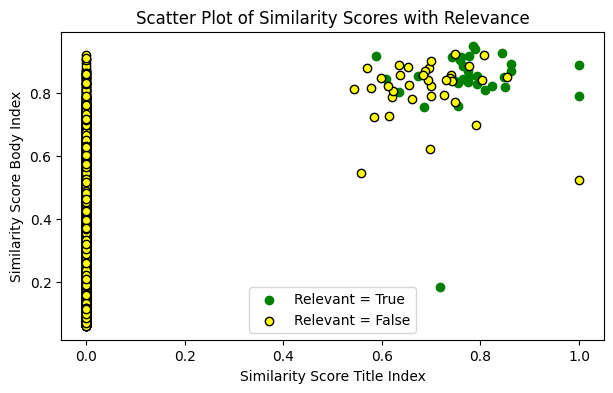

In [28]:
# Sample DataFrame setup
np.random.seed(0)  # For reproducible results
sample_size = 100  # Example sample size
df_example = docs

# Creating the scatter plot
plt.figure(figsize=(7, 4))

# Plotting true values in green
plt.scatter(df_example.loc[df_example['Relevant'], 'Similarity_Score_Title_Index'],
            df_example.loc[df_example['Relevant'], 'Similarity_Score_Body_Index'],
            color='green', label='Relevant = True')

# Plotting false values in light yellow
plt.scatter(df_example.loc[~df_example['Relevant'], 'Similarity_Score_Title_Index'],
            df_example.loc[~df_example['Relevant'], 'Similarity_Score_Body_Index'],
            color='yellow', edgecolor='black', label='Relevant = False')

plt.title('Scatter Plot of Similarity Scores with Relevance')
plt.xlabel('Similarity Score Title Index')
plt.ylabel('Similarity Score Body Index')
plt.legend()
plt.show()

### Generalized Sorting Rules

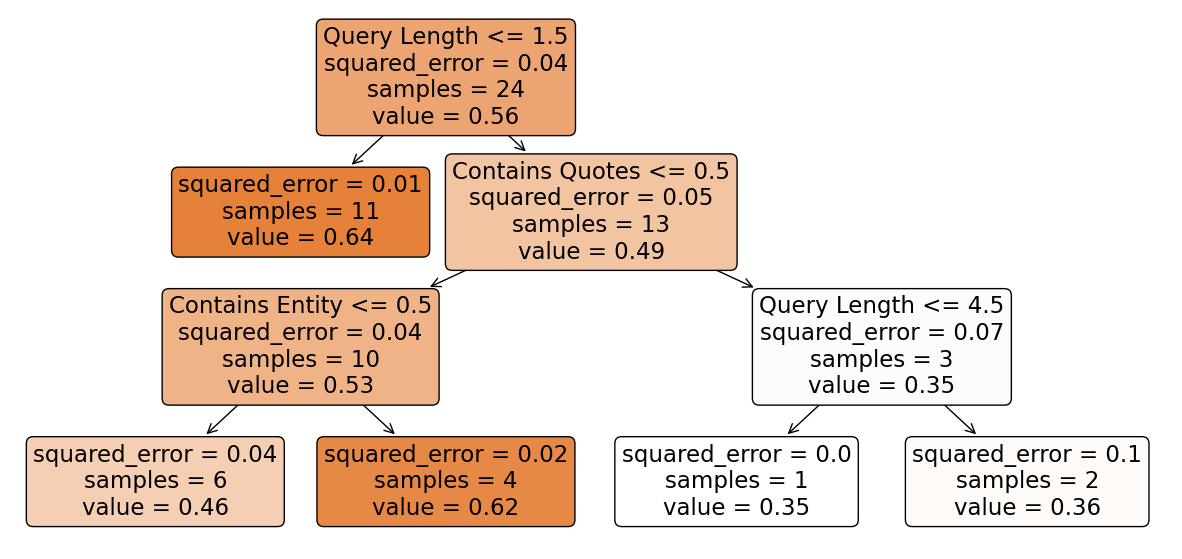

In [35]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
tree_features = ['Query Length', 'Is a Question','Contains Quotes', 'Contains Entity']
target = 'Performance'
# Create a decisional tree for the train and full queries, to decide on query rules
# Filter the dataset for these queries
data = pd.read_excel('/content/measures.xlsx', sheet_name='Queries optimization - No Synon')
filtered_data = data[data['train'] == 1]

# Training the decision tree model on the filtered dataset
tree_regressor_filtered = DecisionTreeRegressor(max_depth=3, random_state=0)
tree_regressor_filtered.fit(filtered_data[tree_features], filtered_data[target])

# Plotting the tree for the filtered dataset
plt.figure(figsize=(15,7))
plot_tree(tree_regressor_filtered, feature_names=tree_features, filled=True, rounded=True, proportion=False, precision=2)
plt.show()

In [43]:
def GetWeights(query):
  '''
  Create weights for the different cases in the
  '''
  query_length = PreprocessQuery(query, False, False)
  if query_length == 1:
    return 0.2, 0.2, 0.2, 0.4
  else:
    if possible_containing_entity(query):
      return 0, 0.8, 0, 0.2
    else:
      return 0.2, 0.4, 0.2, 0.2

In [46]:
results = []
for query in queries_json.keys():
  # if query not in selected_queries:
  docs = BuildFetchedDataSet(query)
  docs[features] = CustomMinMaxScaling(docs, num_threads=None)
  w1, w2, w3, w4 = GetWeights(query)
  docs['Weighted_Score'] = w1 * docs['Similarity_Score_Title_Index'] + \
                                w2 * docs['Similarity_Score_Body_Index'] + \
                                w3 * docs['PageRank'] + \
                                w4 * docs['PageViews']
  results.append(evaluate_performance(query, docs))
print(sum(results) / len(results))

0.44453333333333334


### Final Ranking Function

In [93]:
def GetResults(query):
    '''
    The input for this function are the total documents retrieved and their different scores.
    This function ranks them and return them as [(str(doc_id),title),...].
    Return top 30 docs.
    '''
    features = ['Similarity_Score_Title_Index', 'Similarity_Score_Body_Index',
            'PageRank', 'PageViews']
    fetched_docs = Search_for_Optimization(query, inverted1, inverted2)
    fetched_docs['Query Length'] = len(PreprocessQuery(query, False, False))
    fetched_docs['Contains Entity'] = 1 if possible_containing_entity(query) else 0
    fetched_docs[features] = CustomMinMaxScaling(fetched_docs, num_threads=None)
    w1, w2, w3, w4 = GetWeights(query)
    fetched_docs['Weighted_Score'] = w1 * fetched_docs['Similarity_Score_Title_Index'] + \
                                w2 * fetched_docs['Similarity_Score_Body_Index'] + \
                                w3 * fetched_docs['PageRank'] + \
                                w4 * fetched_docs['PageViews']

    docs = fetched_docs.sort_values('Weighted_Score', ascending=False)[:20000]
    return docs
    # return [(str(doc_id), title) for doc_id, title in zip(docs['Doc_ID'], docs['Title'])]

### Local Time Test

In [58]:
import time
def time_test(queries_json):
  times = []
  for query in queries_json:
    s = time.time()
    GetResults(query)
    e = time.time()
    t = e-s
    times.append(t)
  return sum(times)/len(times)

In [64]:
time_test(queries_json)

11.215993038813274

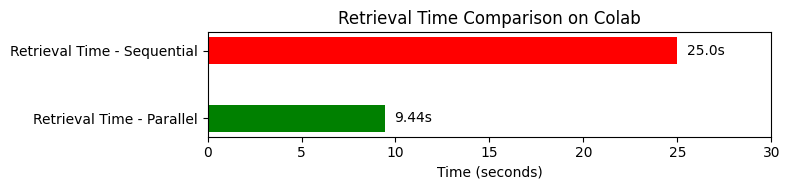

In [71]:
import matplotlib.pyplot as plt

# Data
categories = ['Retrieval Time - Parallel', 'Retrieval Time - Sequential']
times = [9.44, 25]  # Assuming 25+ as 25 for simplicity in visualization

# Creating the plot with a specified figure size
# Reduce the height of the figure to make the plot thinner
fig, ax = plt.subplots(figsize=(8, 2))  # Adjust the figsize to control the overall size of the plot

# Draw the bars closer to each other by adjusting the height parameter
bars = ax.barh(categories, times, color=['green', 'red'], height=0.4)  # Adjust the height for closer bars

# Adding text labels to the bars
for bar in bars:
    width = bar.get_width()
    label_x_pos = width + 0.5  # Adjust this value to place the label closer to the end of the bar
    ax.text(label_x_pos, bar.get_y() + bar.get_height() / 2, f'{width}s', va='center')

# Setting labels and title
ax.set_xlabel('Time (seconds)')
ax.set_title('Retrieval Time Comparison on Colab')
ax.set_xlim(0, 30)


plt.tight_layout()
plt.show()

# Attemps and Research

### ANN Training (MLE)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define your neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Output layer for binary classification
        return x

# Assuming you have your features X and target y defined
# Convert DataFrame to numpy arrays
X_numpy = X.values
y_numpy = y.values

# Convert numpy arrays to PyTorch tensors
X_tensor = torch.tensor(X_numpy, dtype=torch.float32)
y_tensor = torch.tensor(y_numpy, dtype=torch.float32)

# The total number of features
total_features = X_numpy.shape[1]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Preprocessing (standard scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert scaled numpy arrays to PyTorch tensors
X_train_scaled_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_scaled_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)

# Initialize the neural network model
model = NeuralNetwork(total_features)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X_train_scaled_tensor)
    loss = criterion(outputs.squeeze(), y_train)  # Remove the extra dimension from outputs
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch [{epoch + 1}/100], Loss: {loss.item():.4f}')

# Evaluate the model on validation set
with torch.no_grad():
    outputs = model(X_val_scaled_tensor)
    predicted_labels = (outputs >= 0.5).float()
    accuracy = (predicted_labels.squeeze() == y_val).float().mean()

print("Validation Accuracy:", accuracy.item())

In [ ]:
# Preprocess the test set
X_test_scaled = scaler.transform(X_test.values)  # Assuming scaler is already fitted

# Convert scaled numpy array to PyTorch tensor
X_test_scaled_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Pass the preprocessed test set through the trained model
with torch.no_grad():
    outputs = model(X_test_scaled_tensor)
    predicted_probabilities = torch.sigmoid(outputs)

full_test_with_pred = test_ds.copy()
full_test_with_pred['Prediction'] = predicted_probabilities

In [ ]:
import pandas as pd
from sklearn.metrics import precision_score, f1_score

queries = list(set(full_test_with_pred['Query']))
# Sort the DataFrame by predicted probabilities in descending order
query_pred = full_test_with_pred[full_test_with_pred['Query'] == queries[0]]
full_test_with_pred_sorted = full_test_with_pred.sort_values(by='Prediction', ascending=False)
full_test_with_pred_sorted = full_test_with_pred_sorted.reset_index(drop=True)

# Calculate precision@5, precision@10, and F1@30 scores
relevant_labels = full_test_with_pred_sorted['Relevant'].values

# Precision@5
precision_at_5 = precision_score(relevant_labels[:5], relevant_labels[:5])
# Precision@10
precision_at_10 = precision_score(relevant_labels[:10], relevant_labels[:10])
# Precision@50
precision_at_50 = precision_score(relevant_labels[:50], relevant_labels[:50])
# Precision@100
precision_at_100 = precision_score(relevant_labels[:100], relevant_labels[:100])
# F1@30
f1_at_30 = f1_score(relevant_labels[:30], relevant_labels[:30])

print("Precision@5:", precision_at_5)
print("Precision@10:", precision_at_10)
print("Precision@50:", precision_at_50)
print("Precision@100:", precision_at_100)
print("F1@30:", f1_at_30)

Precision@5: 0.0
Precision@10: 0.0
Precision@50: 0.0
Precision@100: 0.0
F1@30: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

### Feature Selection

In [ ]:
from sklearn.linear_model import Lasso, LogisticRegression, ElasticNet
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score

# Define train and test datasets (already split)
# train_df, test_df
irrelevant = ['Doc_ID', 'Title', 'Query']
# Drop the irrelevant columns from train dataset
X_train = train_ds.drop(irrelevant, axis=1)
# Drop the irrelevant columns from test dataset
irrelevant.append('Relevant')
X_test = test_ds.drop(irrelevant, axis=1)
# Separate features and target variable for training dataset
X_train = X_train.drop(columns=['Relevant'])
y_train = train_ds['Relevant']
# Separate features and target variable for test dataset
y_test = test_ds['Relevant']

# Initialize models
lasso = Lasso(alpha=0.1)
rfe = RFE(LogisticRegression(), n_features_to_select=5)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
sfm = SelectFromModel(RandomForestClassifier(n_estimators=100))

# Fit models and print important features
lasso.fit(X_train, y_train)
print("Lasso Important Features:")
print(X_train.columns[lasso.coef_ != 0])

rfe.fit(X_train, y_train)
print("RFE Important Features:")
print(X_train.columns[rfe.support_])

elastic_net.fit(X_train, y_train)
print("Elastic Net Important Features:")
print(X_train.columns[elastic_net.coef_ != 0])

sfm.fit(X_train, y_train)
print("SFM Important Features:")
print(X_train.columns[sfm.get_support()])

Lasso Important Features:
Index(['Similarity_Score_Title_Index', 'Similarity_Score_Body_Index',
       'Similarity_Score_Body_Entity', 'PageRank', 'PageViews',
       'Query Length'],
      dtype='object')
RFE Important Features:
Index(['Similarity_Score_Title_Index', 'Similarity_Score_Body_Index',
       'Similarity_Score_Title_Entity', 'Query Length', 'Contains Quotes'],
      dtype='object')
Elastic Net Important Features:
Index(['Similarity_Score_Title_Index', 'Similarity_Score_Body_Index',
       'Similarity_Score_Body_Entity', 'PageRank', 'PageViews',
       'Query Length'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SFM Important Features:
Index(['Similarity_Score_Title_Index', 'Similarity_Score_Body_Index',
       'PageRank', 'PageViews', 'sum_similarity'],
      dtype='object')


### Train a model

In [ ]:
# Models tried: Logistic Regression (~0.22),

from sklearn.preprocessing import StandardScaler

# Initialize logistic regression model
logistic_model = LogisticRegression()

# Initialize Gradient Boosting Machine (GBM)
gbm_model = GradientBoostingClassifier()

# Initialize AdaBoost
adaboost_model = AdaBoostClassifier()

# Initialize RandomForest
random_forest_model = RandomForestClassifier()

# Initialize LightGBM
lightgbm_model = lgb.LGBMClassifier()

all_columns = ['Similarity_Score_Title_Index', 'Similarity_Score_Body_Index',
       'Similarity_Score_Title_Entity', 'Similarity_Score_Body_Entity',
       'PageRank', 'PageViews', 'Query Length', 'Is a Question',
       'Contains Quotes', 'Contains Entity', 'sum_similarity']

# Define selected features
selected_features = ['Similarity_Score_Title_Index', 'Similarity_Score_Body_Index','Query Length',
                     'Similarity_Score_Body_Entity', 'Similarity_Score_Title_Entity', 'PageRank', 'PageViews']

# selected_features = all_columns
# Fit the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[selected_features])
logistic_model.fit(X_train_scaled, y_train)

# Fit the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[selected_features])
adaboost_model.fit(X_train_scaled, y_train)

# Fit the model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[selected_features])
lightgbm_model.fit(X_train_scaled, y_train)

# Predict probabilities for test set
X_test_scaled = scaler.transform(X_test[selected_features])
y_test_proba = lightgbm_model.predict_proba(X_test_scaled)
test_ds['Prediction'] = y_test_proba[:, 1]

[LightGBM] [Info] Number of positive: 27, number of negative: 26
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 73
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509434 -> initscore=0.037740
[LightGBM] [Info] Start training from score 0.037740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [ ]:
def PredMethod(test_ds, adaboost_model, lightgbm_model, scaler, selected_features):
    # Scale the test features
    X_test_scaled = scaler.transform(test_ds[selected_features])

    # Predict probabilities for each sample using AdaBoost and LightGBM models
    test_ds['Prediction_ADA'] = adaboost_model.predict_proba(X_test_scaled)[:, 1]
    test_ds['Prediction_LGBM'] = lightgbm_model.predict_proba(X_test_scaled)[:, 1]

    # Sort the DataFrame based on the predictions from LightGBM in descending order
    sorted_ds = test_ds.sort_values(by='Prediction_LGBM', ascending=False)

    # Select the top row (best prediction) from LightGBM
    best_lgbm = sorted_ds.iloc[[0]]

    # Select the best predictions from the 'Body' column
    best_body = sorted_ds.sort_values(by='Similarity_Score_Body_Index', ascending=False).iloc[[0]]

    # Select the top two predictions from AdaBoost
    best_ada = sorted_ds.sort_values(by='Prediction_ADA', ascending=False).iloc[:2]

    # Select the top three predictions from the 'Title' column
    best_title = sorted_ds.sort_values(by='Similarity_Score_Title_Index', ascending=False).iloc[:3]

    # Combine all selected rows
    selected_rows = pd.concat([best_lgbm, best_body, best_ada, best_title])

    # Sort the remaining rows by the 'Body' column
    remaining_rows = sorted_ds[~sorted_ds.index.isin(selected_rows.index)].sort_values(by='Similarity_Score_Body_Index', ascending=False)

    # Concatenate selected rows and remaining rows
    final_ds = pd.concat([selected_rows, remaining_rows])

    # Drop duplicates and keep the first occurrence
    final_ds.drop_duplicates(inplace=True)

    return final_ds

In [ ]:
test_sorted = PredMethod(test_ds, adaboost_model, lightgbm_model, scaler, selected_features)
test_sorted

y_true = test_sorted['Relevant']
y_pred = test_sorted['Prediction']
threshold = 0  # basically supposed to mark as 'True' all in the column, and check the top of the column
y_pred_binary = (y_pred > threshold).astype(int)

# Now you can compute precision using the binary predictions
precision_5 = precision_score(y_true[:5], y_pred_binary[:5], zero_division='warn')
f1_30 = f1_score(y_true[:30], y_pred_binary[:30], zero_division='warn')

# Print the best sorting options and their scores
print("==========================================================================================")
print("\nPrecision@5:", precision_5,'\n')
print("\nF1@30:", f1_30,'\n')
print("==========================================================================================")


Precision@5: 0.4 


F1@30: 0.33333333333333337 



In [ ]:
sorted_relevant_test_ds = test_ds.sort_values(by='Prediction', ascending=False)[:100]
sorted_relevant_test_ds.reset_index(drop=True, inplace=True)

relevant_test_ds = sorted_relevant_test_ds[sorted_relevant_test_ds['Relevant'] == True]

# Extract the indexes of the relevant samples within the first 100 rows
indexes_of_relevant_samples = relevant_test_ds.index.tolist()
indexes_of_relevant_samples

[0, 8]

In [ ]:
# Sorting methods:
# Based on 'Similarity_Score_Title_Index': [2, 26]
# Based on 'Similarity_Score_Body_Index': [0, 5, 9, 15, 47]
# Based on 'Prediction - Logistic Regression': [16, 34, 35]
# Based on 'Prediction - Ada Boost - feature selection': [1]
# Based on 'Prediction - Ada Boost': [4]
# Based on 'Prediction - LightGBM - feature selection': [0, 8]
# Based on 'Prediction - LightGBM': [29, 30]

### Model Assessment

In [ ]:
from sklearn.metrics import precision_score, f1_score

# Define sorting orders to test
sorting_orders = [
    ['Similarity_Score_Title_Index'],
    ['Similarity_Score_Body_Index'],
    ['Prediction'],
    ['Similarity_Score_Title_Index', 'Similarity_Score_Body_Index'],
    ['Similarity_Score_Body_Index', 'Similarity_Score_Title_Index'],
    ['Similarity_Score_Title_Index', 'Prediction'],
    ['Prediction', 'Similarity_Score_Title_Index'],
    ['Similarity_Score_Body_Index', 'Prediction'],
    ['Prediction', 'Similarity_Score_Body_Index'],
    ['Similarity_Score_Title_Index', 'Similarity_Score_Body_Index', 'Prediction'],
    ['Similarity_Score_Title_Index', 'Prediction', 'Similarity_Score_Body_Index'],
    ['Similarity_Score_Body_Index', 'Similarity_Score_Title_Index', 'Prediction'],
    ['Similarity_Score_Body_Index', 'Prediction', 'Similarity_Score_Title_Index'],
    ['Prediction', 'Similarity_Score_Title_Index', 'Similarity_Score_Body_Index'],
    ['Prediction', 'Similarity_Score_Body_Index', 'Similarity_Score_Title_Index'],
]

# Define function to calculate precision@5 and F1@30
def evaluate_sorting_order(data, sorting_order):
    sorted_data = data.sort_values(by=sorting_order, ascending=False)
    y_true = sorted_data['Relevant']
    y_pred = sorted_data['Prediction']
    threshold = 0  # basically supposed to mark as 'True' all in the column, and check the top of the column
    y_pred_binary = (y_pred > threshold).astype(int)

    # Now you can compute precision using the binary predictions
    precision_5 = precision_score(y_true[:5], y_pred_binary[:5], zero_division='warn')
    f1_30 = f1_score(y_true[:30], y_pred_binary[:30], zero_division='warn')
    return precision_5, f1_30

# Calculate precision@5 and F1@30 for each sorting order
best_precision_5 = 0
best_f1_30 = 0
best_sorting_order_precision_5 = None
best_sorting_order_f1_30 = None

for sorting_order in sorting_orders:
    precision_5, f1_30 = evaluate_sorting_order(test_ds, sorting_order)
    if precision_5 > best_precision_5:
        best_precision_5 = precision_5
        best_sorting_order_precision_5 = sorting_order
    if f1_30 > best_f1_30:
        best_f1_30 = f1_30
        best_sorting_order_f1_30 = sorting_order

# Print the best sorting options and their scores
print("==========================================================================================")
print("\nBest sorting order for precision@5:", best_sorting_order_precision_5, "with precision@5:", best_precision_5,'\n')
print("\nBest sorting order for F1@30:", best_sorting_order_f1_30, "with F1@30:", best_f1_30,'\n')
print("==========================================================================================")


Best sorting order for precision@5: ['Similarity_Score_Title_Index'] with precision@5: 0.2 


Best sorting order for F1@30: ['Similarity_Score_Body_Index'] with F1@30: 0.23529411764705882 



## Time Optimization

Can we cut the Body Index posting list by TF to save space and actions?

In [ ]:
# Let's create a query on the body and look for a connection between tf and BM25 score.
# If we can determine a threshold for TF that will most definetly ignore irrelevant docs - we will improve time
# Will be tested for single worded queries to see the connection directly between a tokens tf and the BM25
query = 'America'
query_tokens = PreprocessQuery(query,False, False)
p = RetrieveFromPosting(query_tokens, inverted2, BASE_DIR_B, BUCKET_NAME, {}, {})
d = []
docs = {}
threaded_search(query_tokens, inverted2, BASE_DIR_B, 'BM25', docs, 'key_suffix')

In [ ]:
keys = [key for key in p.keys()]
values = p[keys[0]]
doc_tf = {tup[0]:tup[2] for tup in values}

In [ ]:
docs_bm = docs['key_suffix']
docs_bm

points = [(doc_tf[doc], docs_bm[doc][1]) for doc in docs_bm.keys()]

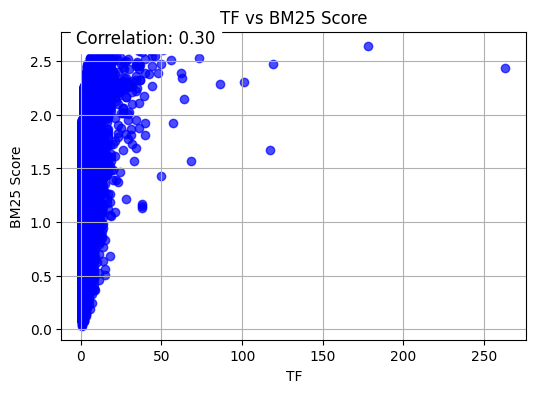

In [ ]:
import matplotlib.pyplot as plt

doc_tf = {tup[0]:tup[2] for tup in values}
points = [(doc_tf[doc], docs_bm[doc][1]) for doc in docs_bm.keys()]
# Extract tf and BM25 scores into separate lists for plotting
tf_scores, bm25_scores = zip(*points)

# Plot scatter
plt.figure(figsize=(6, 4))
plt.scatter(tf_scores, bm25_scores, color='blue', alpha=0.7)
plt.title('TF vs BM25 Score')
plt.xlabel('TF')
plt.ylabel('BM25 Score')
plt.grid(True)

# Calculate and display correlation
correlation = np.corrcoef(tf_scores, bm25_scores)[0, 1]
plt.figtext(0.15, 0.85, f"Correlation: {correlation:.2f}", fontsize=12, backgroundcolor='white')

plt.show()

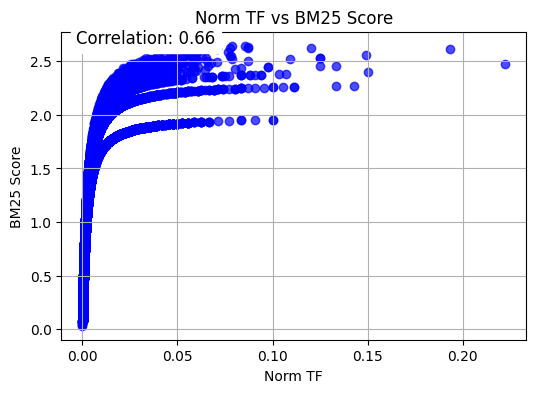

In [ ]:
doc_tf = {tup[0]:(tup[2]/tup[3]) for tup in values}
points = [(doc_tf[doc], docs_bm[doc][1]) for doc in docs_bm.keys()]
# Extract tf and BM25 scores into separate lists for plotting
tf_scores, bm25_scores = zip(*points)

# Plot scatter
plt.figure(figsize=(6, 4))
plt.scatter(tf_scores, bm25_scores, color='blue', alpha=0.7)
plt.title('Norm TF vs BM25 Score')
plt.xlabel('Norm TF')
plt.ylabel('BM25 Score')
plt.grid(True)

# Calculate and display correlation
correlation = np.corrcoef(tf_scores, bm25_scores)[0, 1]
plt.figtext(0.15, 0.85, f"Correlation: {correlation:.2f}", fontsize=12, backgroundcolor='white')

plt.show()

### Multithreads on Similarity methods - helpful?

In [ ]:
import time

times_o = []
times_n = []

for query in queries['Text']:

  query_tokens = PreprocessQuery(query, expand=True, synonims=False, expansion_param=2)
  fetched_docs = RetrieveFromPosting(query_tokens, inverted2, BASE_DIR_B, BUCKET_NAME, PageRank, PageViews, method='BM25')

  # Timing BM25_Similarity
  start_time_o = time.time()
  docs_o = BM25_Similarity(fetched_docs, inverted2.AVG_doc_length, query_tokens, k1=1.5, b=0.75)
  end_time_o = time.time()
  times_o.append(end_time_o - start_time_o)

  # Timing BM25_Similarity_Parallel
  start_time_n = time.time()
  docs_n = BM25_Similarity_Parallel(fetched_docs, inverted2.AVG_doc_length, query_tokens, k1=1.5, b=0.75)
  end_time_n = time.time()
  times_n.append(end_time_n - start_time_n)

print(f"Time for BM25_Similarity_Parallel: {sum(times_n)/len(times_n)} seconds")
print(f"Time for BM25_Similarity: {sum(times_o)/len(times_o)} seconds")

Time for BM25_Similarity_N: 1.4043163537979126 seconds
Time for BM25_Similarity: 0.3973235289255778 seconds


### Analize similarity bottom thresh for true results per index

In [ ]:
# all_true = []

# for query in queries_json.keys():
#   true_ds = BuildFetchedDataSet_Test(query)
#   all_true.append(true_ds[true_ds['Relevant'] == True])

# all_true = pd.concat(all_true)
# all_true.to_excel('Query_Res_all_True.xlsx')
features = ['Similarity_Score_Title_Index',	'Similarity_Score_Body_Index',	'PageRank',	'PageViews']
min_max_values = {}

for query in queries_json.keys():
  true_ds = BuildFetchedDataSet_Test(query)
  for feature in features:
    min_vals = np.min(true_ds[feature], axis=0)
    max_vals = np.max(true_ds[feature], axis=0)
    if feature not in min_max_values:
      min_max_values[feature] = (min_vals,max_vals)
    else:
      min_max_values[feature] = (min(min_vals, min_max_values[feature][0]) ,max(max_vals, min_max_values[feature][1]))

In [ ]:
min_max_values

{'Similarity_Score_Title_Index': (0, 1.0000000000000002),
 'Similarity_Score_Body_Index': (0.2500000344706341, 8.205944171811298),
 'PageRank': (0.0, 9.201776686284328),
 'PageViews': (0.0, 19.014704766035365)}

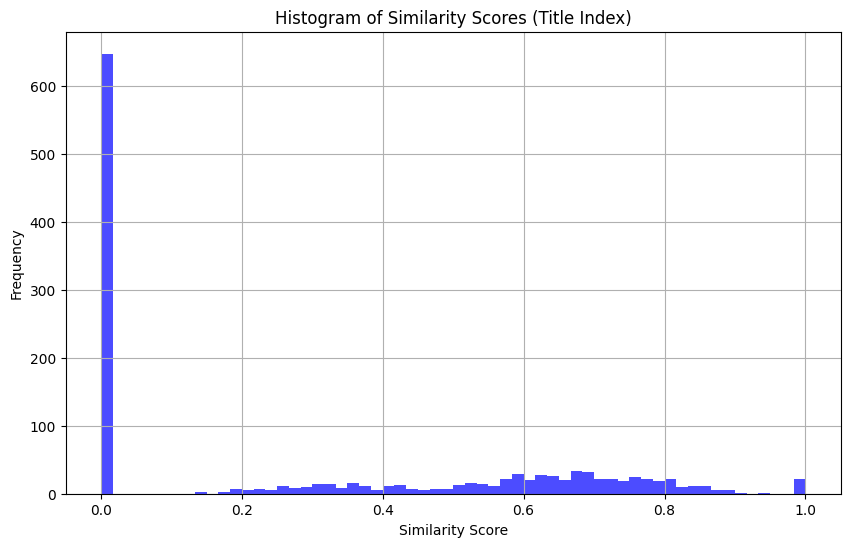

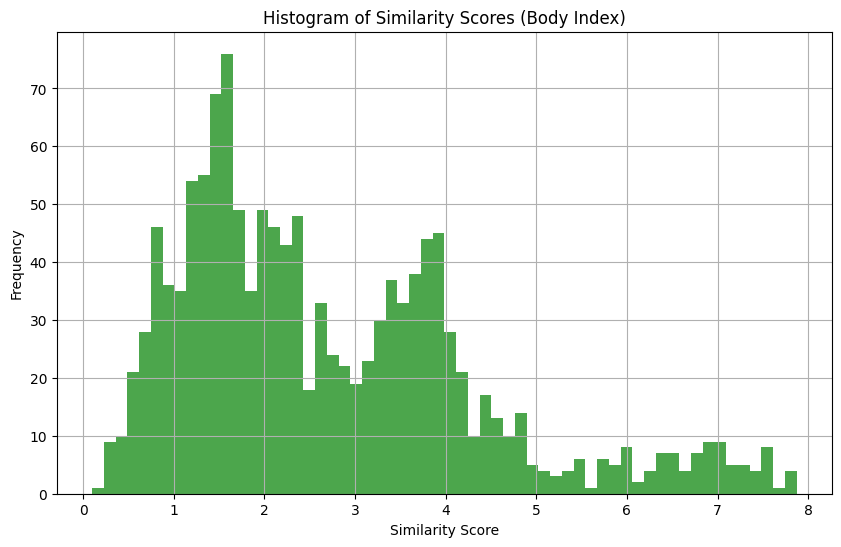

In [ ]:
import matplotlib.pyplot as plt

# Plot histogram for Similarity_Score_Title_Index
plt.figure(figsize=(10, 6))
plt.hist(all_true['Similarity_Score_Title_Index'], bins=60, color='blue', alpha=0.7)
plt.title('Histogram of Similarity Scores (Title Index)')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot histogram for Similarity_Score_Body_Index
plt.figure(figsize=(10, 6))
plt.hist(all_true['Similarity_Score_Body_Index'], bins=60, color='green', alpha=0.7)
plt.title('Histogram of Similarity Scores (Body Index)')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Threshold 0.5: Retained 98.39% of data
Threshold 0.51: Retained 98.32% of data
Threshold 0.52: Retained 98.16% of data
Threshold 0.53: Retained 98.09% of data
Threshold 0.54: Retained 98.09% of data
Threshold 0.55: Retained 97.93% of data
Threshold 0.56: Retained 97.63% of data
Threshold 0.5700000000000001: Retained 97.48% of data
Threshold 0.5800000000000001: Retained 97.40% of data
Threshold 0.5900000000000001: Retained 97.32% of data
Threshold 0.6000000000000001: Retained 97.25% of data
Threshold 0.6100000000000001: Retained 97.02% of data
Threshold 0.6200000000000001: Retained 96.86% of data
Threshold 0.6300000000000001: Retained 96.71% of data
Threshold 0.6400000000000001: Retained 96.71% of data
Threshold 0.6500000000000001: Retained 96.71% of data
Threshold 0.6600000000000001: Retained 96.48% of data
Threshold 0.6700000000000002: Retained 96.17% of data
Threshold 0.6800000000000002: Retained 95.94% of data
Threshold 0.6900000000000002: Retained 95.79% of data
Threshold 0.7000000

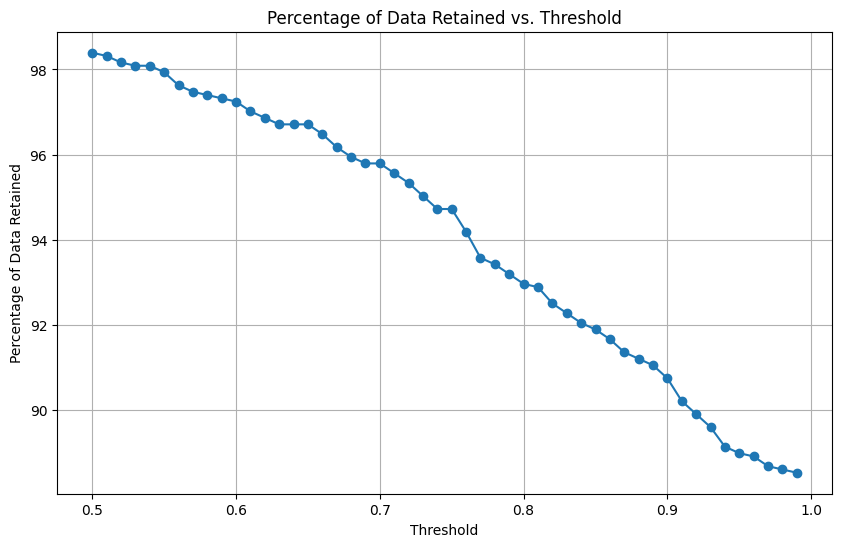

In [ ]:

# Example dataset (replace with your actual data)
similarity_scores = all_true['Similarity_Score_Body_Index']
non_zero_scores_mask = similarity_scores != 0
similarity_scores = similarity_scores[non_zero_scores_mask]

# Total number of data points
total_data_points = len(similarity_scores)

# Define thresholds to try
thresholds = np.arange(0.5, 1, 0.01)  # Adjust as needed

# Calculate percentage of data points retained for each threshold
percentages_retained = []
for threshold in thresholds:
    num_retained = np.sum(similarity_scores >= threshold)
    percentage_retained = (num_retained / total_data_points) * 100
    percentages_retained.append(percentage_retained)
    print(f"Threshold {threshold}: Retained {percentage_retained:.2f}% of data")

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, percentages_retained, marker='o')
plt.title('Percentage of Data Retained vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Percentage of Data Retained')
plt.grid(True)
plt.show()